In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.metrics import roc_curve, auc

https://towardsdatascience.com/machine-learning-predicting-bank-loan-defaults-d48bffb9aee2

https://medium.com/latinxinai/logistic-regression-in-credit-risk-the-role-of-weight-of-evidence-and-information-value-9e26dd690b16

https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451

# Loading Data

In [ ]:
df = pd.read_csv("cr_loan.csv")
df['client_id'] = range(1, len(df) + 1)
cols = ['client_id'] + [col for col in df if col != 'client_id']
df = df[cols]

df.head()

,client_id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,1,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,2,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,3,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,4,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,5,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
df.dtypes

client_id                       int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

# Cross Table Functions

In [ ]:
def crosstab2(df, column1, column2):
    crosstab_table = pd.crosstab(df[column1], df[column2], margins=True)
    return crosstab_table

In [ ]:
def crosstab3(df, column1, column2, column3):
    crosstab_table = pd.crosstab(df[column1], [df[column2], df[column3]], margins=True)
    return crosstab_table

In [ ]:
table1 = crosstab2(df, "loan_intent", "loan_status")
table1

loan_status,0,1,All
loan_intent,,,
DEBTCONSOLIDATION,3722,1490,5212
EDUCATION,5342,1111,6453
HOMEIMPROVEMENT,2664,941,3605
MEDICAL,4450,1621,6071
PERSONAL,4423,1098,5521
VENTURE,4872,847,5719
All,25473,7108,32581


In [ ]:
#table1.to_csv('intent_vs_status.csv', index=True)

In [ ]:
# Using the function
table2 = crosstab3(df, "person_home_ownership", "loan_status", "loan_grade")
table2

loan_status               0                                   1              \
loan_grade                A     B     C     D    E   F  G     A     B     C   
person_home_ownership                                                         
MORTGAGE               5219  3729  1934   658  178  36  0   239   324   321   
OTHER                    23    29    11     9    2   0  0     3     5     6   
OWN                     860   770   464   264   26   7  0    66    34    31   
RENT                   3602  4222  2710   554  137  28  1   765  1338   981   
All                    9704  8750  5119  1485  343  71  1  1073  1701  1339   

loan_status                                  All  
loan_grade                D    E    F   G         
person_home_ownership                             
MORTGAGE                553  161   61  31  13444  
OTHER                    11    6    2   0    107  
OWN                      18   31    8   5   2584  
RENT                   1559  423   99  27  16446  
All                    2141  621  170  63  32581

## Outliers

In [ ]:
#pd.crosstab(df["person_home_ownership"], df["loan_status"], values=df["loan_int_rate"], aggfunc="mean").round(2)

In [ ]:
print(pd.crosstab(df["loan_status"],df["person_home_ownership"],
                  values=df["person_emp_length"], aggfunc="max"))

person_home_ownership  MORTGAGE  OTHER   OWN   RENT
loan_status                                        
0                         123.0   24.0  31.0   41.0
1                          34.0   11.0  17.0  123.0


It may not be possible for a person to have an employment length of less than 0 or greater than 60. You can use cross tables to check the data and see if there are any instances of this. Generally with credit data, key columns like "person_emp_length" are of high quality, but there is always room for error.

With this in hand, we can build intuition for detecting outliers.

In [ ]:
# Create an array of indices where employment length is greater than 60
indices = df[df['person_emp_length'] > 60].index
print(indices)

Int64Index([0, 210], dtype='int64')


In [ ]:
cr_loan_new = df.drop(indices)

In [ ]:
# Create the cross table from earlier and include minimum employment length
print(pd.crosstab(cr_loan_new['loan_status'],cr_loan_new['person_home_ownership'],
            values=cr_loan_new['person_emp_length'], aggfunc=['min','max']))

                           min                      max                  
person_home_ownership MORTGAGE OTHER  OWN RENT MORTGAGE OTHER   OWN  RENT
loan_status                                                              
0                          0.0   0.0  0.0  0.0     38.0  24.0  31.0  41.0
1                          0.0   0.0  0.0  0.0     34.0  11.0  17.0  27.0


# Missing Values (KEEP, REPLACE, AND REMOVE)

In [ ]:
missing_value = df.isnull().sum() # checking for missing values
print("Number of missing values: ", missing_value)

Number of missing values:  client_id                        0
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [ ]:
employment_length = df[df['person_emp_length'].isnull()] # Print the top five rows with nulls for employment length
employment_length.head()

,client_id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
105,106,22,12600,MORTGAGE,NaN,PERSONAL,A,2000,5.42,1,0.16,N,4
222,223,24,185000,MORTGAGE,NaN,EDUCATION,B,35000,12.42,0,0.19,N,2
379,380,24,16800,MORTGAGE,NaN,DEBTCONSOLIDATION,A,3900,NaN,1,0.23,N,3
407,408,25,52000,RENT,NaN,PERSONAL,B,24000,10.74,1,0.46,N,2
408,409,22,17352,MORTGAGE,NaN,EDUCATION,C,2250,15.27,0,0.13,Y,3


Bar graph shows "person_emp_length" data skewed to the right.

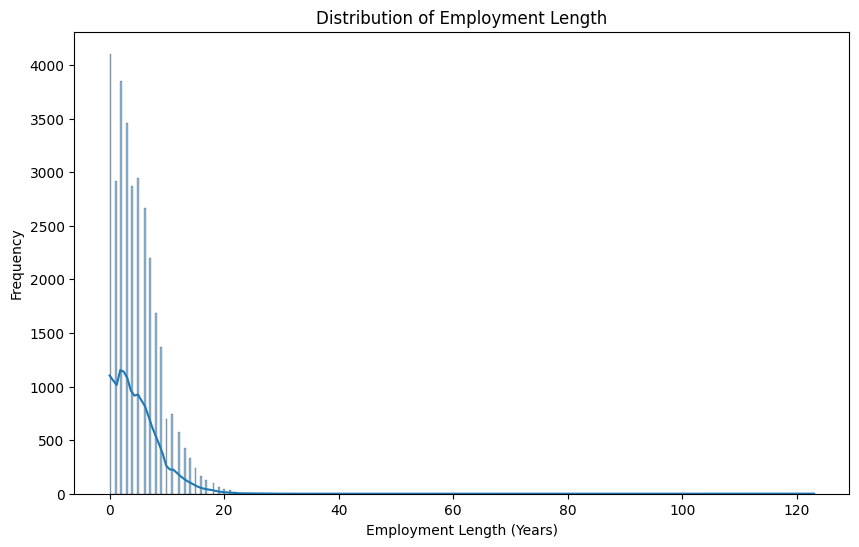

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['person_emp_length'], kde=True)
plt.title('Distribution of Employment Length')
plt.xlabel('Employment Length (Years)')
plt.ylabel('Frequency')
plt.show()

Since employment length data is missing and the bar graph shows that data is skewed to the right, I am going to be using "median" to replace those missing values as it is less sensitive to outliers.

In [ ]:
#median_emp_length = df["person_emp_length"].median() # missing values with median
#df["person_emp_length"].fillna(median_emp_length, inplace=True)

In [ ]:
int_rate = df[df['loan_int_rate'].isnull()] # Print the top five rows with nulls for employment length
int_rate.head()

,client_id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
39,40,23,71500,RENT,3.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.42,N,4
50,51,24,78000,RENT,4.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.38,Y,4
57,58,23,277000,OWN,3.0,PERSONAL,A,35000,NaN,0,0.13,N,4
59,60,24,12000,OWN,2.0,VENTURE,E,1750,NaN,0,0.15,Y,3
62,63,26,263000,MORTGAGE,0.0,EDUCATION,B,10000,NaN,1,0.04,N,4


Having missing data in "loan_int_rate" is not common and might be due an error. I'm dropping the foollowing interest rates missing values for now.

In [ ]:
df.shape

(32581, 13)

In [ ]:
df_new = df.dropna(subset=["loan_int_rate"]) # dropping those missing values for loan_int_rate column

In [ ]:
df_new.shape

(29465, 13)

# Data proccesing (One-Hot Encoding) and Feature Engineering

In [ ]:
df_new.head()

,client_id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,1,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,2,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,3,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,4,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,5,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Creating new column containing ID for client

In [ ]:
df_new.dtypes

client_id                       int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [ ]:
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

In [ ]:
# numerical pipeline
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', MinMaxScaler())  # preprocessing: normalize the features of my dataset within a range of 0 and 1
])

# categorical pipeline
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))  # One-hot encode categorical data
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ])

# Machine Learning

In [ ]:
X = df_new.drop(['client_id', 'loan_status'], axis=1) # feature inputs for classification
y = df_new['loan_status'] # target labels we want to predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #0.3
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #0.5

## Logistic Regression

In [ ]:
pipeline = Pipeline(steps=[
                          ('preprocessor', preprocessor),
                          ('classifier', LogisticRegression())
                          ])

In [ ]:
#param_grid = {
    #'classifier__C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
    #'classifier__solver': ['lbfgs', 'saga', 'newton-cg'],
    #'classifier__penalty': ['none', 'l1', 'l2', 'elasticnet']
#}

param_grid = [
    {'classifier__solver': ['lbfgs', 'newton-cg'],
     'classifier__penalty': ['l2', 'none'],
     'classifier__C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]},

    {'classifier__solver': ['saga'],
     'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
     'classifier__C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
     'classifier__l1_ratio': [0.5]}  # elasticnet
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['person_age',
                                                                          'person_income',
                                                                          'person_emp_length',
                                                                          'loan_amnt',
                                                                          'loan_int_rate',
                                                                          'loan_percent_income',
                                                                          'cb_person_cred_hist_length']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encode...
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier__C': [0.001, 0.01, 0.1, 1.0, 10, 100,
                                            1000],
                          'classifier__penalty': ['l2', 'none'],
                          'classifier__solver': ['lbfgs', 'newton-cg']},
                         {'classifier__C': [0.001, 0.01, 0.1, 1.0, 10, 100,
                                            1000],
                          'classifier__l1_ratio': [0.5],
                          'classifier__penalty': ['l1', 'l2', 'elasticnet',
                                                  'none'],
                          'classifier__solver': ['saga']}],
             scoring='accuracy', verbose=1)

In [ ]:
print("Best parameters found:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Best parameters found: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}


## Training

In [ ]:
# Now you can use best_model to make predictions
y_pred_train = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

print("Train accuracy:", train_accuracy)

Train accuracy: 0.8649838256350427


## Validation

In [ ]:
y_pred_valid = best_model.predict(X_valid)
val_accuracy = accuracy_score(y_valid, y_pred_valid)

print("Validation accuracy:", val_accuracy)

Validation accuracy: 0.8702014846235419


## Visualizing Accuracy Performance

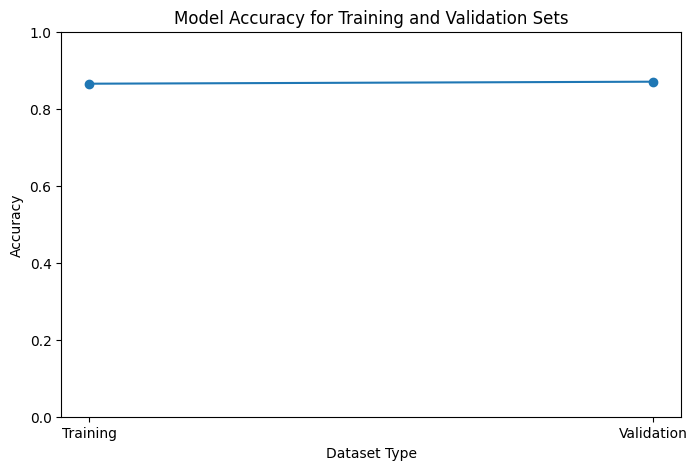

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(['Training', 'Validation'], [train_accuracy, val_accuracy], marker='o')
plt.xlabel('Dataset Type')
plt.ylabel('Accuracy')
plt.title('Model Accuracy for Training and Validation Sets')
plt.ylim([0, 1])  # Assuming accuracy is between 0 and 1
plt.show()

The train and validation accuracies, as well as the above graph, show that the logistic regression model is performing well to unseen data. There is no indication of overitting (validation accuracy is not significantly lower than training accuracy) and no indication of underfitting (both accuracies are relatively high).

## Testing

In [ ]:
y_pred = best_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Testing Accuracy:", accuracy)

Testing Accuracy: 0.8666214152384185


## Classification Report and Confusion Matrix

In [ ]:
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4585
           1       0.77      0.57      0.66      1308

    accuracy                           0.87      5893
   macro avg       0.83      0.76      0.79      5893
weighted avg       0.86      0.87      0.86      5893



In [ ]:
confusion_mtx = confusion_matrix(y_test, y_pred)
print(confusion_mtx)

[[4359  226]
 [ 560  748]]


[[TN  FP]

 [FN  TP]]





TN: True negatives (correctly predicted negatives) -> 4359

FP: False positives (incorrectly predicted positives) -> 226

FN: False negatives (incorrectly predicted negatives) -> 560

TP: True positives (correctly predicted positives) -> 748

## Visual Results

In [ ]:
results = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),
    'Predicted': y_pred
})

# Step 2: Flag correct and incorrect predictions
results['Correct Prediction'] = results['Actual'] == results['Predicted']

In [ ]:
results.head()

,Actual,Predicted,Correct Prediction
0,0,0,True
1,0,0,True
2,0,0,True
3,0,0,True
4,0,0,True


In [ ]:
results.to_csv('risk_logistic.csv', index=True)

In [ ]:
correct_count = results['Correct Prediction'].sum()
incorrect_count = (~results['Correct Prediction']).sum()

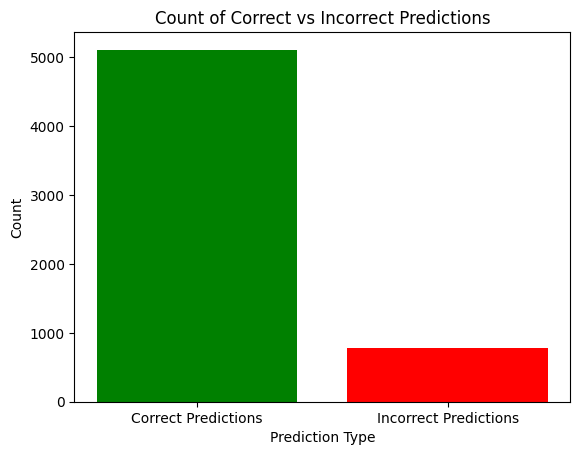

In [ ]:
labels = ['Correct Predictions', 'Incorrect Predictions']
counts = [correct_count, incorrect_count]

plt.bar(labels, counts, color=['green', 'red'])
plt.xlabel('Prediction Type')
plt.ylabel('Count')
plt.title('Count of Correct vs Incorrect Predictions')
plt.show()

In [ ]:
incorrect_predictions = results[~results['Correct Prediction']]
incorrect_counts = incorrect_predictions['Actual'].value_counts()
print(incorrect_counts)

1    560
0    226
Name: Actual, dtype: int64


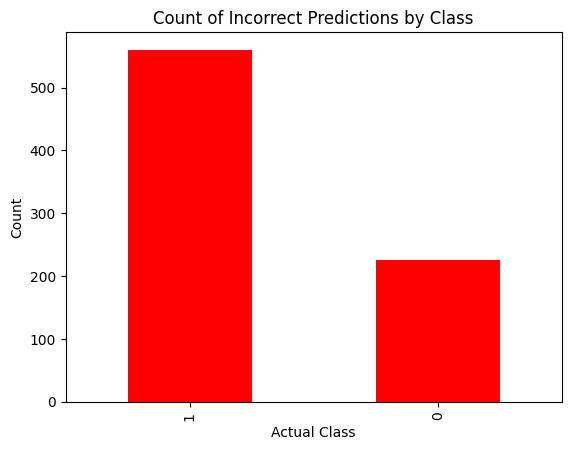

In [ ]:
incorrect_counts.plot(kind='bar', color='red')
plt.xlabel('Actual Class')
plt.ylabel('Count')
plt.title('Count of Incorrect Predictions by Class')
plt.show()

# Probability of Deafult

Predict_proba method returns the probability estimates for each class. The output is an array with shape (n_samples, n_classes) where the classes are ordered as they appear in the classes_ attribute of the classifier.

In [ ]:
# Probability of Default array -> pd for each instance wihtin the Test set (unseen data)
PD = best_model.predict_proba(X_test)[:, 1]  # default class is second column

In [ ]:
print(best_model.named_steps['classifier'].classes_) # printing classes of classifier

[0 1]


In [ ]:
PD

array([0.31592396, 0.08857273, 0.30142167, ..., 0.8766783 , 0.04221247,
       0.22035115])

# ROC Curve (For Binary Classification)

Performance: The ROC curve provides a comprehensive view of a model's performance at all classification thresholds. This is particularly useful for imbalanced datasets or when the costs of false positives and false negatives are very different.

Threshold: It helps in selecting an optimal threshold that balances the true positive rate and false positive rate according to the problem's requirement.

The ROC curve can be used to compare the performance of multiple classifiers. A model that lies closer to the top-left corner indicates a better performance.

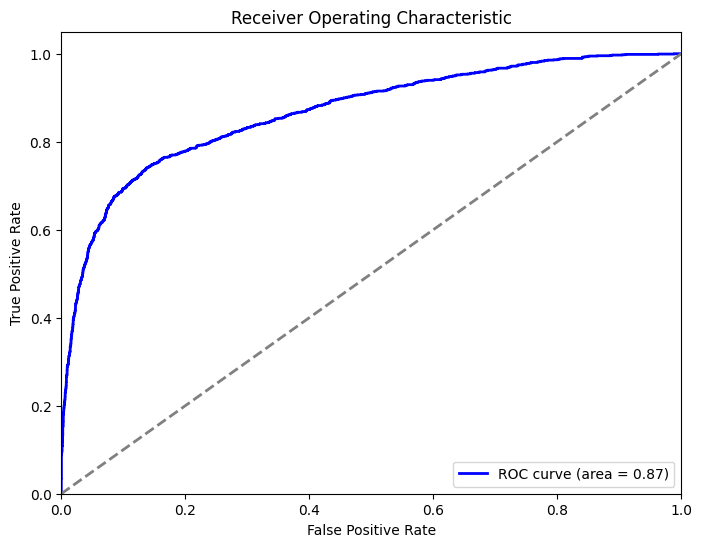

In [ ]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, PD)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculating Expected Loss:

In [ ]:
# Assume a constant LGD for demonstration purposes, say 0.45
LGD = 0.45

# Convert the numpy array of PDs to a pandas Series with the same index as X_test for easy concatenation
PD_series = pd.Series(PD, index=X_test.index, name='Probability_of_Default')

# Concatenate the PDs to your X_test DataFrame
X_test = pd.concat([X_test, PD_series], axis=1)

# Calculate Expected Loss for each loan
X_test['Expected_Loss'] = X_test['Probability_of_Default'] * X_test['loan_amnt'] * LGD

# Now you can inspect the first few rows to see the Expected Loss along with the other columns
expected_loss_df = X_test.head()